In [592]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [893]:
#calculate the distance between one point to many points
def euclidean_d (point, points):
    return np.sqrt(np.sum((point-points)**2,axis=1))
    # return np.sqrt(np.sum((point1 - point2)**2))
    # temp = point1 - point2
    # return np.sqrt(np.dot(temp.T, temp))

def knn (train_data, test_data,k):
    y_pred = []
    #print(distance.cdist(np.array(train_data.iloc[:,:-1]),np.array(test_data.iloc[:,:-1]),'euclidean'))
    for j in range(len(test_data)):
        distance = euclidean_d(np.array(test_data.iloc[j,:-1]),np.array(train_data.iloc[:,:-1]))
        neighbour = {"y_value": train_data.Prediction,"distance":distance}
        neighbour = pd.DataFrame(neighbour, columns = ['y_value','distance'])
        neighbour = neighbour.sort_values(by = 'distance', kind='mergesort').iloc[:k,] 
        values, counts = np.unique(neighbour.y_value, return_counts=True)
        y_pred.append(int(values[counts == counts.max()][0]))
    return y_pred

def knn_confidence (train_data, test_data,k):
    confidence_positive = []
    for j in range(len(test_data)):
        distance = euclidean_d(np.array(test_data.iloc[j,:-1]),np.array(train_data.iloc[:,:-1]))
        neighbour = {"y_value": train_data.Prediction,"distance":distance}
        neighbour = pd.DataFrame(neighbour, columns = ['y_value','distance'])
        neighbour = neighbour.sort_values(by = 'distance', kind='mergesort').iloc[:k,] 
        temp = neighbour.loc[neighbour.y_value==1,'y_value']
        confidence_positive.append(len(temp)/k)
    return confidence_positive
    
def cross_validation(k, data, model,model_parameter):
    accuracy = []
    precision = []
    recall = []
    for i in range(k):
        test_data = data.iloc[i*len(data)//k:(i+1)*len(data)//k,:]
        training_data_front = data.iloc[0:i*len(data)//k,:]
        training_data_back = data.iloc[(i+1)*len(data)//k:,:]
        training_data = pd.concat([training_data_front,training_data_back],ignore_index=True, sort=False)
        if(model==gradient_descent):
            theta = model(5000, training_data, model_parameter)
            values = logistic_reg(theta,test_data)
            for i in range(len(values)):
                if values[i] >= 0.5:
                    values[i] = 1
                else:
                    values[i] = 0
            test_data.insert(test_data.shape[1],"model_prediction",values)
        else:
            test_data.insert(test_data.shape[1],"model_prediction",model(training_data,test_data,model_parameter))
        accuracy.append(len(test_data[test_data['Prediction']==test_data['model_prediction']])/len(test_data))
        precision.append(len(test_data[(test_data['Prediction']==1)&(test_data['model_prediction']==1)])/(len(test_data[(test_data['Prediction']==1) & (test_data['model_prediction']==1)])+len(test_data[(test_data['Prediction']==0) & (test_data['model_prediction']==1)])))
        recall.append(len(test_data[(test_data['Prediction']==1)&(test_data['model_prediction']==1)])/(len(test_data[(test_data['Prediction']==1) & (test_data['model_prediction']==1)])+len(test_data[(test_data['Prediction']==1) & (test_data['model_prediction']==0)])))
    return (accuracy, precision, recall)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def logistic_reg(theta, data):
    temp = np.array(data.iloc[:,:-1]).dot(theta.T)
    return sigmoid(temp)

def gradient_descent(epoch, data, lamda):
    theta = np.repeat(0,data.shape[1]-1)
    for i in range(epoch):
        step = (logistic_reg(theta, data)-data.Prediction).dot(data.iloc[:,:-1])/len(data)
        #print(np.sum(abs((logistic_reg(theta, data)-data.Prediction))))
        theta = theta - lamda * step
    return theta

def confidence_level(data,model,model_parameter):
    i = 4
    k = 5
    test_data = data.iloc[i*len(data)//k:(i+1)*len(data)//k,:]
    training_data_front = data.iloc[0:i*len(data)//k,:]
    training_data_back = data.iloc[(i+1)*len(data)//k:,:]
    training_data = pd.concat([training_data_front,training_data_back],ignore_index=True, sort=False)
    if(model==gradient_descent):
        theta = model(5000, training_data, model_parameter)
        values = logistic_reg(theta,test_data)
        test_data.insert(test_data.shape[1],"confidence_positive",values)
    else:
        test_data.insert(test_data.shape[1],"confidence_positive",model(training_data,test_data,model_parameter))
    test_data = test_data.sort_values(by =['confidence_positive','Prediction'], kind='mergesort',ascending=[False,True])
    return test_data

def roc_curve(data):
    threshoulds = [{'FPR':0, 'TPR':0}]
    num_neg = len(data[data['Prediction']==0])
    num_positive = len(data[data['Prediction']==1])
    TP = 0
    FP = 0
    last_TP = 0
    for i in range(0,len(data)):
        if((i > 0) and (data.iloc[i,-1]!=data.iloc[i-1,-1])
           and (data.iloc[i,-2]==0) and (TP>last_TP)):
            FPR = FP/num_neg
            TPR = TP/num_positive
            threshoulds.append({'FPR':FPR, 'TPR':TPR})
            last_TP = TP
        if data.iloc[i,-2] == 1:
            TP += 1 
        else:
            FP += 1
    FPR = FP/num_neg
    TPR = TP/num_positive
    threshoulds.append({'FPR':FPR, 'TPR':TPR})
    return threshoulds
            

In [634]:
## 2.2
emails = pd.read_csv('emails.csv',index_col=0)
accuracy, precision, recall = cross_validation(5,emails, knn,1)
print("Accuracy:", accuracy, "Pression:",precision, "Recall:",recall)

Accuracy: [0.825, 0.853, 0.862, 0.851, 0.775] Pression: [0.6544943820224719, 0.6857142857142857, 0.7212121212121212, 0.7164179104477612, 0.6057441253263708] Recall: [0.8175438596491228, 0.8664259927797834, 0.8380281690140845, 0.8163265306122449, 0.7581699346405228]


In [ ]:
accuracy, precision, recall = cross_validation(5,emails, gradient_descent,0.0005)
print("Accuracy:", accuracy, "Pression:",precision, "Recall:",recall)

In [636]:
accuracy_k = [] 
emails = pd.read_csv('emails.csv',index_col=0)
accuracy, precision, recall = cross_validation(5,emails, knn,1)
accuracy_k.append({'k':1, 'accuracy':np.mean(accuracy)})
print(accuracy_k)

accuracy, precision, recall = cross_validation(5,emails, knn,3)
accuracy_k.append({'k':3, 'accuracy':np.mean(accuracy)})
print(accuracy_k)

accuracy, precision, recall = cross_validation(5,emails, knn,5)
accuracy_k.append({'k':5, 'accuracy':np.mean(accuracy)})
print(accuracy_k)

accuracy, precision, recall = cross_validation(5,emails, knn,7)
accuracy_k.append({'k':7, 'accuracy':np.mean(accuracy)})
print(accuracy_k)

accuracy, precision, recall = cross_validation(5,emails, knn,10)
accuracy_k.append({'k':10, 'accuracy':np.mean(accuracy)})
accuracy_k

[{'k': 1, 'accuracy': 0.8332}]
[{'k': 1, 'accuracy': 0.8332}, {'k': 3, 'accuracy': 0.8423999999999999}]
[{'k': 1, 'accuracy': 0.8332}, {'k': 3, 'accuracy': 0.8423999999999999}, {'k': 5, 'accuracy': 0.8417999999999999}]
[{'k': 1, 'accuracy': 0.8332}, {'k': 3, 'accuracy': 0.8423999999999999}, {'k': 5, 'accuracy': 0.8417999999999999}, {'k': 7, 'accuracy': 0.8454}]


[{'k': 1, 'accuracy': 0.8332},
 {'k': 3, 'accuracy': 0.8423999999999999},
 {'k': 5, 'accuracy': 0.8417999999999999},
 {'k': 7, 'accuracy': 0.8454},
 {'k': 10, 'accuracy': 0.8552}]

In [ ]:
df = pd.DataFrame(accuracy_k)
plt.plot(df.k,df.accuracy,'-o',c='steelblue')
plt.xlabel('k')
plt.ylabel('Average Accuracy')
plt.title('kNN 5-Fold Cross Validation')
plt.grid()
plt.show()

In [897]:
confidence_logreg = confidence_level(emails, gradient_descent,0.0005)
confidence_logreg

confidence_knn = confidence_level(emails, knn_confidence, 5)
confidence_knn

,the,to,ect,and,for,of,a,you,hou,in,...,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction,confidence_positive
Email No.,,,,,,,,,,,,,,,,,,,,,
Email 4081,0,2,1,0,1,0,23,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
Email 4085,0,2,1,0,1,0,23,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
Email 4146,1,1,1,1,1,1,9,2,0,1,...,0,0,0,0,0,0,0,0,0,1.0
Email 4259,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
Email 4267,7,11,1,1,1,2,39,11,0,11,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Email 4608,1,0,1,0,1,0,5,0,0,1,...,0,0,0,0,0,0,0,0,0,0.8
Email 4625,9,2,1,5,12,3,67,1,0,30,...,0,0,0,0,0,0,0,0,0,0.8
Email 4641,14,15,3,13,9,6,104,0,0,40,...,0,0,0,0,0,0,5,0,0,0.8


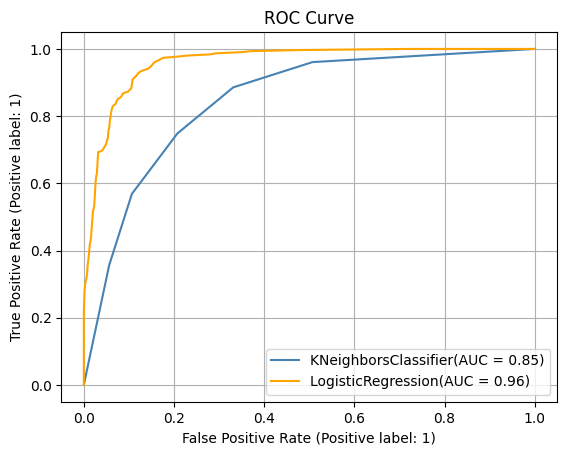

[{'FPR': 0, 'TPR': 0},
 {'FPR': 0.0, 'TPR': 0.21568627450980393},
 {'FPR': 0.001440922190201729, 'TPR': 0.2777777777777778},
 {'FPR': 0.002881844380403458, 'TPR': 0.3006535947712418},
 {'FPR': 0.005763688760806916, 'TPR': 0.31699346405228757},
 {'FPR': 0.007204610951008645, 'TPR': 0.3300653594771242},
 {'FPR': 0.008645533141210375, 'TPR': 0.35947712418300654},
 {'FPR': 0.010086455331412104, 'TPR': 0.37254901960784315},
 {'FPR': 0.011527377521613832, 'TPR': 0.39215686274509803},
 {'FPR': 0.012968299711815562, 'TPR': 0.4150326797385621},
 {'FPR': 0.01585014409221902, 'TPR': 0.43790849673202614},
 {'FPR': 0.018731988472622477, 'TPR': 0.49019607843137253},
 {'FPR': 0.020172910662824207, 'TPR': 0.5163398692810458},
 {'FPR': 0.021613832853025938, 'TPR': 0.5228758169934641},
 {'FPR': 0.023054755043227664, 'TPR': 0.5326797385620915},
 {'FPR': 0.024495677233429394, 'TPR': 0.565359477124183},
 {'FPR': 0.025936599423631124, 'TPR': 0.6013071895424836},
 {'FPR': 0.027377521613832854, 'TPR': 0.62091

In [898]:
temp = roc_curve(confidence_knn)
df = pd.DataFrame(temp)
plt.plot(df.FPR,df.TPR,'-',c='steelblue',label = "KNeighborsClassifier(AUC = "+str(round(np.trapz(df.TPR,df.FPR),2))+")")


temp = roc_curve(confidence_logreg)
df = pd.DataFrame(temp)
plt.plot(df.FPR,df.TPR,'-',c='orange',label = "LogisticRegression(AUC = "+str(round(np.trapz(df.TPR,df.FPR),2))+")")

plt.xlabel('False Positive Rate (Positive label: 1)')
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.title('ROC Curve')
plt.grid()
plt.legend()
plt.show()